# Transaction Amount Prediction - Regression
### Lifecycle
![Business Model Canvas](../images/lifecycle.png)



## Plan

### Business Model Canvas

![Business Model Canvas](../images/business-model-canvas.png)

### Use case
We would like to create a machine learning model that allows us to predict the transaction volume a customer is likely to generate when making a purchase.

By embedding our payment method in other stores, the stores transfer anonymized data of a purchase to us during the payment process, for example the product category or the product id.

This data is merged with our master data that is obtained when the user registers for our service.

We want to use the capabilities of this merged dataset to create value for our company using a machine learning model.

### Problem
With a more precise knowledge of future transactions, better forecasts and statements can be made about the financial future of the company. 

Thus, strategic decisions such as investments or further development of the product range can be better made with this additional knowledge. 

In addition, it could increase the value of the company on the stock market if we can already provide our investors with a (good) outlook on the expected transaction volume in advance.


### Relevant metrics
***MAE*** - Mean Average Error, the amount which the predictions deviate from the actual values. It measures the accuracy for continuous varibale, in our case the purchase.

Since the MAE is a linear score, each individual difference in the prediction is weighted equally which makes it robust to outliers - other than for example the root mean squared error which gives a relatively high weight to large errors.

Assuming we have a very very poor predictive value but all other values are very accurate, the model would be very good but the RMSE would still be higher than the MAE.

<img src="../images/mae.png" width="300"/> <img src="../images/mse.png" width="300"/>

***RMSE*** - Root Mean Squared Error, mostly the same as MAE but penalizes large deviation more than small deviation.

RMSE is derived by:

1. Squaring the differences between known and unknown points

2. adding them

3. dividing by the number of test points (this is the ***MSE***: Mean Squared Error)

4. and then taking the square root of this result.


Another metric to consider is the ***R squared measure***, which is measured in percent between 0 and 1.

Because of that you can tell at one glimpse how good the model may work. 

However it is a very simple indicator and not the preferred one when it comes to tell how good the model is performing.

For MSE, MAE and RMSE you need to know if 1000 is a large or a small deviation, you need to know the distribution of the taget variable in your dataset. 

The r-squared value can also be interpreted if you do not know the data.
Since r-squared measures the percentage of the target variable is explained by our model, 100 % is the best value possible, so higher values are better. 

MSE, RMSE and MAE are negatively oriented scores - lower values are better





## Data


In [424]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import *

Read in our dataset using pandas and check the first 10 entries

In [132]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.head(10)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969
5,1000003,P00193542,M,26-35,15,A,3,0,1,2.0,NaN,15227
6,1000004,P00184942,M,46-50,7,B,2,1,1,8.0,17.0,19215
7,1000004,P00346142,M,46-50,7,B,2,1,1,15.0,NaN,15854
8,1000004,P0097242,M,46-50,7,B,2,1,1,16.0,NaN,15686
9,1000005,P00274942,M,26-35,20,A,1,1,8,NaN,NaN,7871


In [260]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 550068 entries, 23824 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 70.7+ MB


The dataset consists of 12 features where Purchase is the target variable.

7 features have numeric datatypes and 5 features have the datatype object because they are probably categorical values.

We see that there are missing values in two product file categories, we will explore this further in the analysis.

In total the dataset contains 550068 feature vectors with associated target variable.

Check for "Null" values

In [133]:
df_train.isna().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

There are many zero values in the product category 3 and some zero values in the product category 2.

We look at what proportion these zero values have in relation to the whole dataset.

<AxesSubplot:>

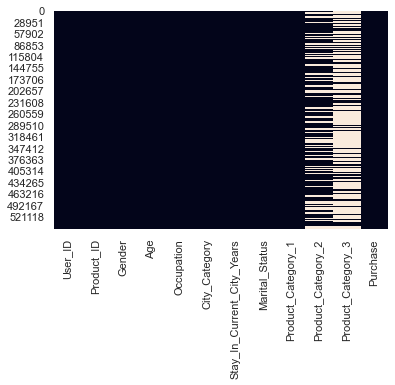

In [134]:
sns.heatmap(df_train.isnull(), cbar=False)

By visualizing the zero values using the heatmap, we can see how many values are missing in relation to the other values.

First we sort by category 2, so that all null values of category 2 are behind each other.

Then we sort the dataframe again by category 3 so that as much as possible is kept from the first sort.

We are mainly interested in category 3. We sort last by category 3 to get all null values in a row. 

<AxesSubplot:>

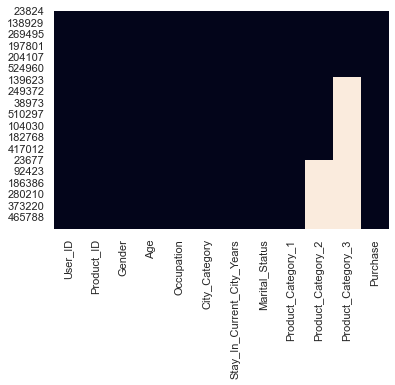

In [135]:
df_heatmap = df_train
df_heatmap.sort_values('Product_Category_2', inplace=True)
df_heatmap.sort_values('Product_Category_3', inplace=True)
sns.heatmap(df_heatmap.isnull(), cbar=False)

A pattern is revealed: All missing values of category 2 are also missing values of category 3.

This means that the zero values from category 3 are related to those from category 2, this form of missing data is called missing not at random (MNAR).

This could be due to the fact that each product is assigned to at least one category, and the other categories are optional.

We will therefore use only category 1 for further visualization of the products by category.

/Users/alexander/miniforge3/envs/aa/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


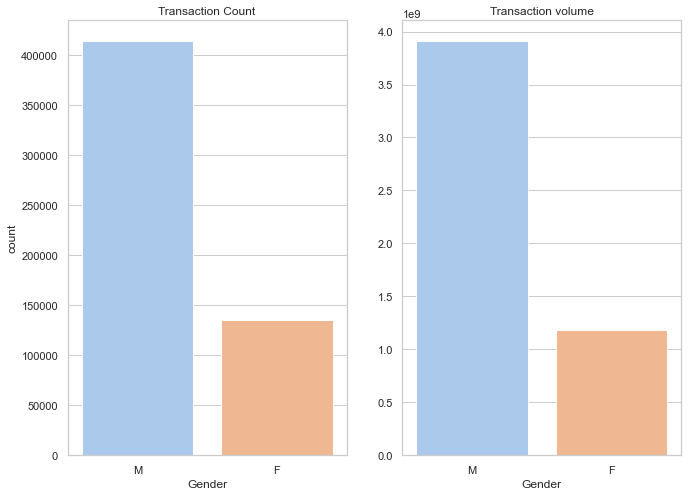

In [249]:
fig, ax = plt.subplots(1, 2, figsize=(11, 8))

sns.countplot(df_train['Gender'], order = df_train['Gender'].value_counts().index, ax=ax[0])
ax[0].set_title('Transaction Count')

purchased = df_train.groupby(by='Gender').sum()['Purchase']
purchased = purchased.sort_values(ascending=False)
sns.barplot(x=purchased.index,y=purchased.values, ax=ax[1], order=purchased.index)
plt.title('Transaction volume')
plt.show()

Men generate about two-thirds of the transactions and at the same time two-thirds of the sales.

Women correspondingly generate about one-third.

/Users/alexander/miniforge3/envs/aa/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


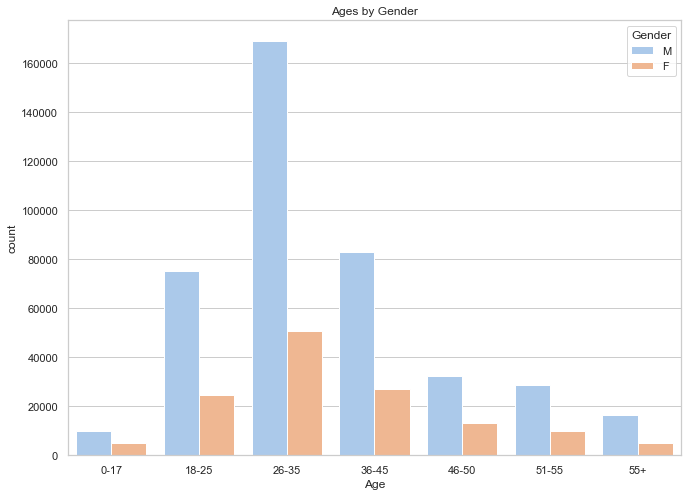

In [178]:
fig, ax = plt.subplots(1, 1, figsize=(11, 8))
sns.countplot(df_train['Age'], hue=df_train['Gender'], order=list(df_train.Age.sort_values().unique()), ax=ax)
plt.title("Ages by Gender")
plt.show()

For both men and women, the age groups from 26 to 35 are most frequently represented.

Overall, the age distribution shows a normal distribution, which is advantageous for our regression model.

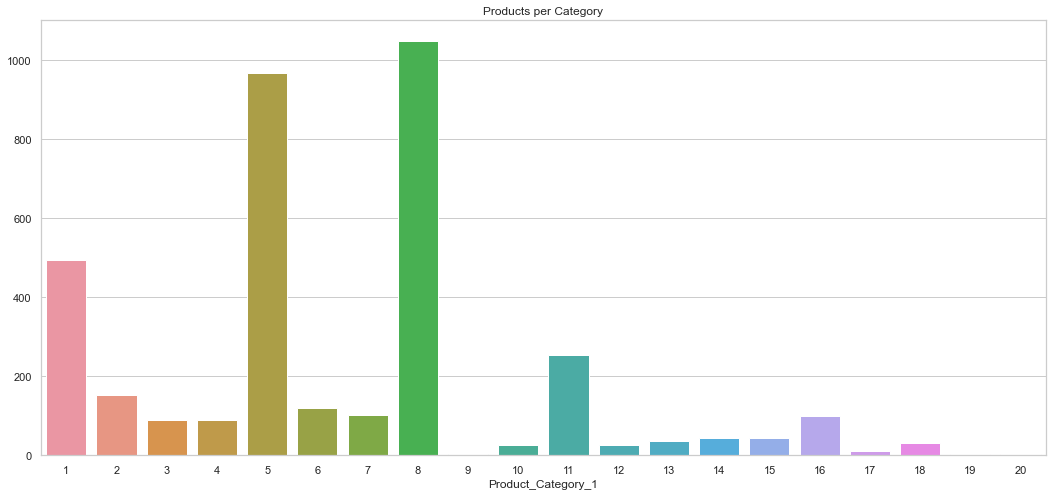

In [253]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
products = df_train.groupby('Product_Category_1')['Product_ID'].nunique()
sns.barplot(x=products.index, y=products.values)
plt.title('Products per Category')
plt.show()

The most products has category 8 together with category 5 and 1

/Users/alexander/miniforge3/envs/aa/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


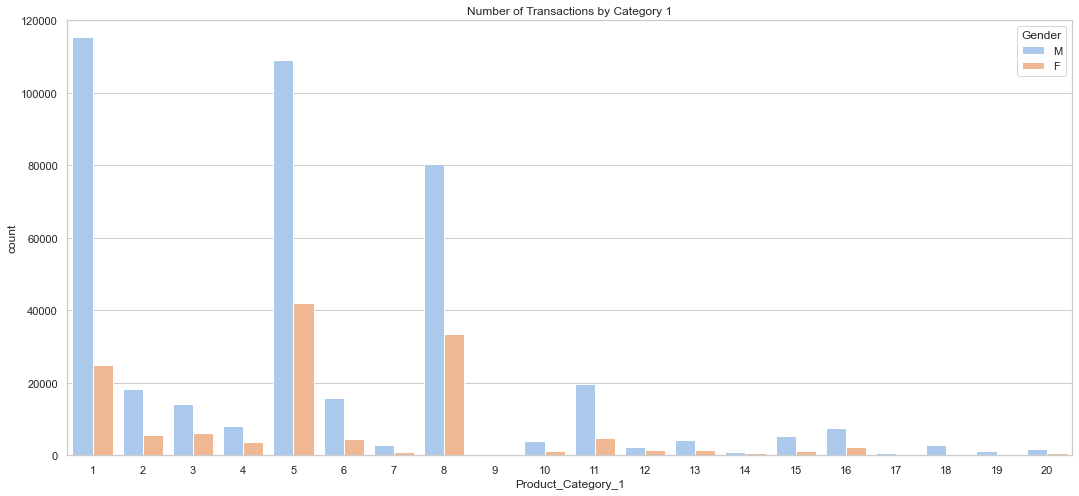

In [261]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.set(ylim=(0, 120000))
ax.set_title('Number of Transactions by Category 1')
sns.countplot(df_train['Product_Category_1'], hue=df_train['Gender'], ax=ax, order=list(df_train.Product_Category_1.sort_values().unique()))
#sns.countplot(df_train['Product_Category_2'], hue=df_train['Gender'], ax=ax[1], order=list(df_train.Product_Category_1.sort_values().unique()))
#sns.countplot(df_train['Product_Category_3'], hue=df_train['Gender'], ax=ax[2], order=list(df_train.Product_Category_1.sort_values().unique()))
plt.show()


Products 1, 5 and 8 are the three most popular products among male customers.

The same products are also the most most popular among women

There is no discernible preference that a product is only demanded by men or women, for example certain hygiene or cosmetics items.

/Users/alexander/miniforge3/envs/aa/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


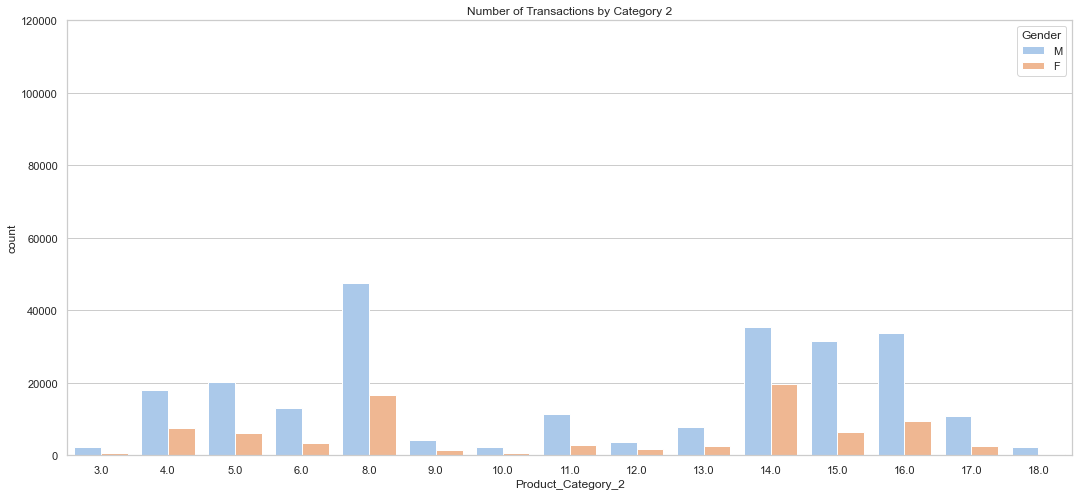

In [271]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.set(ylim=(0, 120000))
ax.set_title('Number of Transactions by Category 2')
#sns.countplot(df_train['Product_Category_1'], hue=df_train['Gender'], ax=ax, order=list(df_train.Product_Category_1.sort_values().unique()))
sns.countplot(df_train['Product_Category_2'], hue=df_train['Gender'], ax=ax, order=list(df_train.Product_Category_2.dropna().sort_values().unique()))
#sns.countplot(df_train['Product_Category_3'], hue=df_train['Gender'], ax=ax[2], order=list(df_train.Product_Category_1.sort_values().unique()))
plt.show()

Here we can see that products in category 18 were bought only by men.

/Users/alexander/miniforge3/envs/aa/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


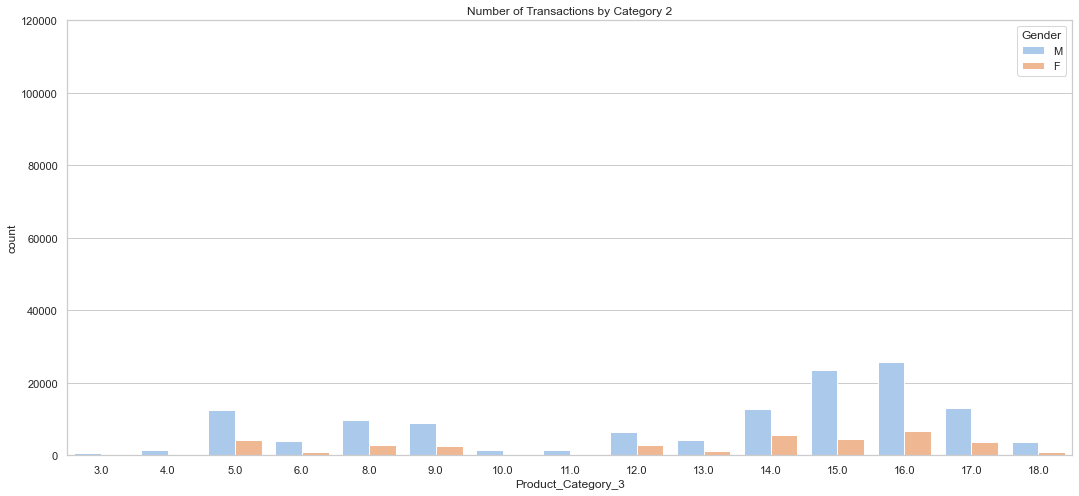

In [270]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.set(ylim=(0, 120000))
ax.set_title('Number of Transactions by Category 3')
#sns.countplot(df_train['Product_Category_1'], hue=df_train['Gender'], ax=ax, order=list(df_train.Product_Category_1.sort_values().unique()))
#sns.countplot(df_train['Product_Category_2'], hue=df_train['Gender'], ax=ax, order=list(df_train.Product_Category_1.sort_values().unique()))
sns.countplot(df_train['Product_Category_3'], hue=df_train['Gender'], ax=ax, order=list(df_train.Product_Category_3.dropna().sort_values().unique()))
plt.show()

Here we can see that products in category 10, 11, 3, 4 were bought only by men.

Let's take a closer look at these peculiarities, perhaps there is an important insight behind them.

To to this we select only those categories which seems to be bought only by men

In [313]:
df_men = df_train.loc[(df_train['Product_Category_3'].isin([3,4,11]) | df_train['Product_Category_2'].isin([18]))]
grouped = df_men.groupby('Product_Category_2')['Gender']
grouped.value_counts()

Product_Category_2  Gender
2.0                 M         2248
                    F          477
3.0                 M         1023
                    F          328
6.0                 M          160
                    F           57
18.0                M         2292
                    F          478
Name: Gender, dtype: int64

We see that the number of female buyers is very low, but female buyers do buy these products.

The original assumption that certain products would only be bought by men was therefore wrong.

/Users/alexander/miniforge3/envs/aa/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


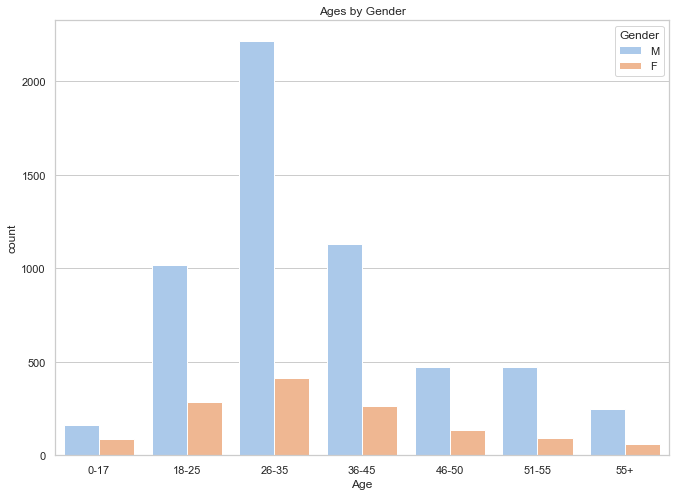

In [275]:
fig, ax = plt.subplots(1, 1, figsize=(11, 8))
sns.countplot(df_men['Age'], hue=df_men['Gender'], order=list(df_men.Age.sort_values().unique()), ax=ax)
plt.title("Ages by Gender")
plt.show()

/Users/alexander/miniforge3/envs/aa/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


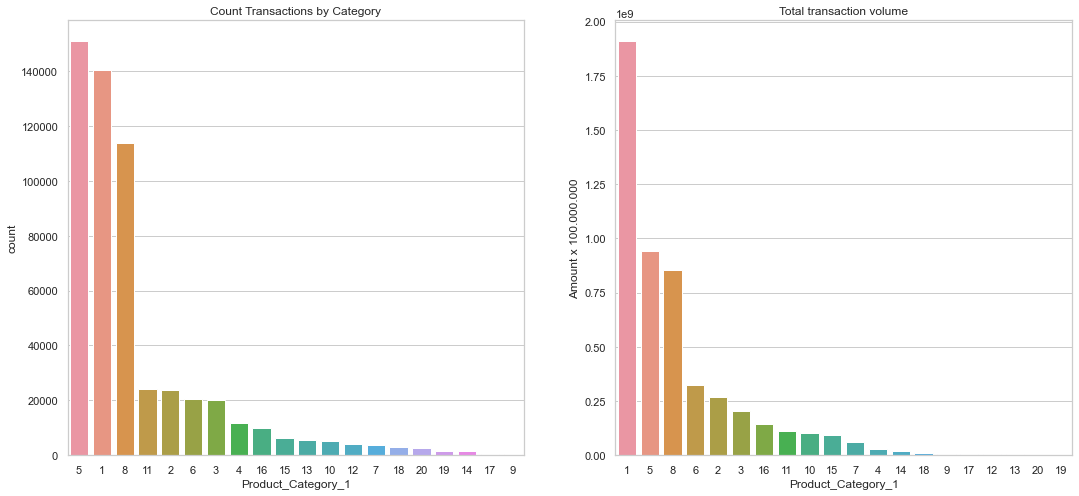

In [259]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.countplot(df_train['Product_Category_1'], order = df_train['Product_Category_1'].value_counts().index, ax=ax[0])
ax[0].set_title('Count Transactions by Category')

plt.ylabel('Amount x 100.000.000')

purchased = df_train.groupby(by='Product_Category_1').sum()['Purchase']
purchased = purchased.sort_values(ascending=False)
sns.barplot(x=purchased.index,y=purchased.values, ax=ax[1], order=purchased.index)
plt.title('Total transaction volume')
plt.show()

As already seen, the products in categories 5, 1 and 8 are the most popular, are sold most frequently and also account for the largest share of the transaction volume.

Products 13, 12, 11 and 4 make relatively little turnover taking into account the purchases. This could indicate that products in this category are cheap.

/Users/alexander/miniforge3/envs/aa/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


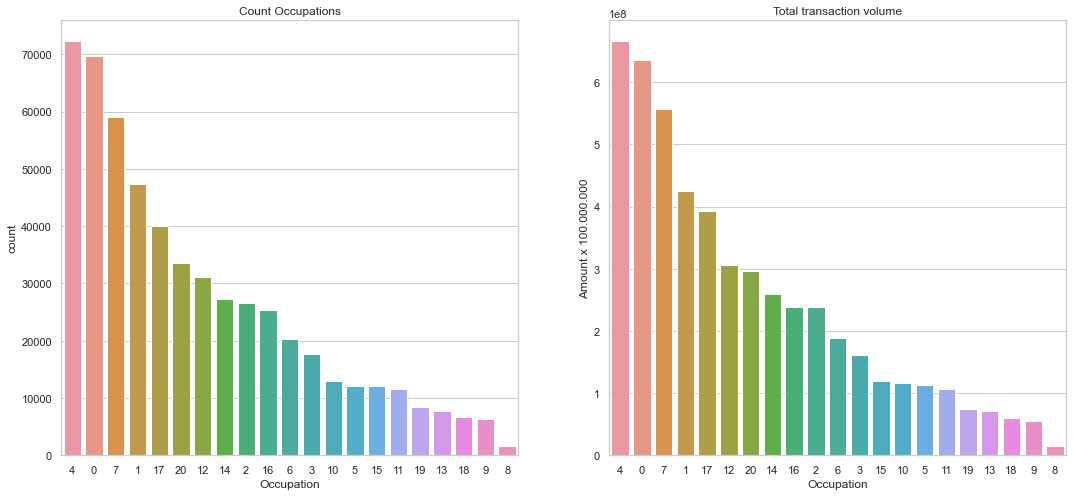

In [255]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.countplot(df_train['Occupation'], order = df_train['Occupation'].value_counts().index, ax=ax[0])
ax[0].set_title('Count Occupations')

plt.ylabel('Amount x 100.000.000')

purchased = df_train.groupby(by='Occupation').sum()['Purchase']
purchased = purchased.sort_values(ascending=False)
sns.barplot(x=purchased.index,y=purchased.values, ax=ax[1], order=purchased.index)
plt.title('Total transaction volume')
plt.show()

The occupational groups in which the most customers are represented also make the most transaction volume. 

Occupations 4, 0 and 7 are the top 3 occupations, occurring most frequently.

/Users/alexander/miniforge3/envs/aa/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


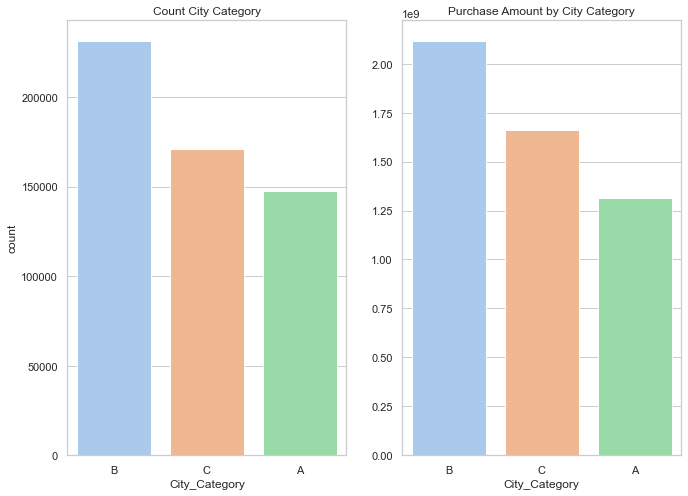

In [215]:
fig, ax = plt.subplots(1, 2, figsize=(11, 8))

sns.countplot(df_train['City_Category'], order = df_train['City_Category'].value_counts().index, ax=ax[0])
ax[0].set_title('Count City Category')

purchased = df_train.groupby(by='City_Category').sum()['Purchase']
purchased = purchased.sort_values(ascending=False)
sns.barplot(x=purchased.index,y=purchased.values, ax=ax[1], order=purchased.index)
ax[1].set_title('Purchase Amount by City Category')
plt.show()

This is similar to the situation with the professional groups: 

The share of the category's transaction volume increases with the number of customers in the category.

/Users/alexander/miniforge3/envs/aa/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


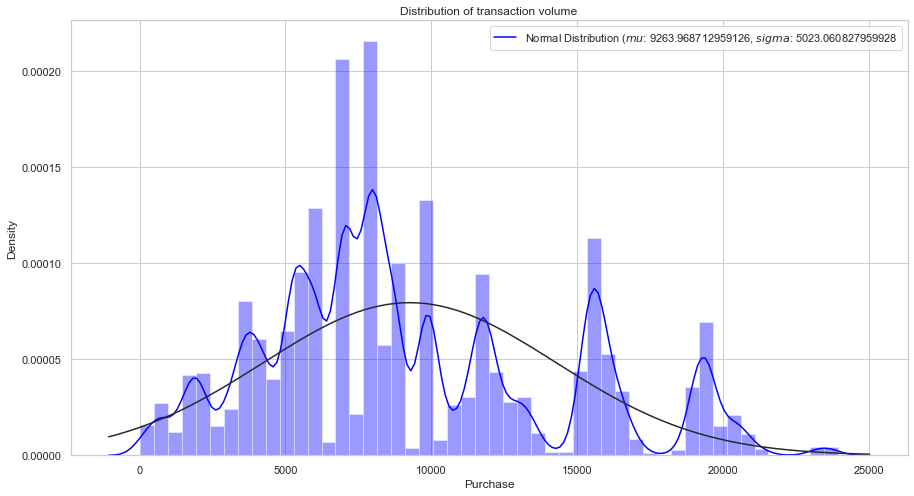

In [241]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.distplot(df_train['Purchase'], color = 'blue', fit = norm)
m, s = norm.fit(df_train['Purchase']) 
plt.title('Distribution of transaction volume')
plt.legend([f'Normal Distribution ($mu$: {mu}, $sigma$: {s}'], loc = 'best')
plt.show()

since we are performing a regression, it is important that the features of our dataset are normally distributed, since the regression model is based on the assumption that the underlying data have a normal distribution.

Here we can see the target variable with a normal distribution with sigma 5023 and mean of 9263.


In [346]:
top_customers.head(10)

User_ID
1004277    10536909
1001680     8699596
1002909     7577756
1001941     6817493
1000424     6573609
1004448     6566245
1005831     6512433
1001015     6511314
1003391     6477160
1001181     6387961
Name: Purchase, dtype: int64

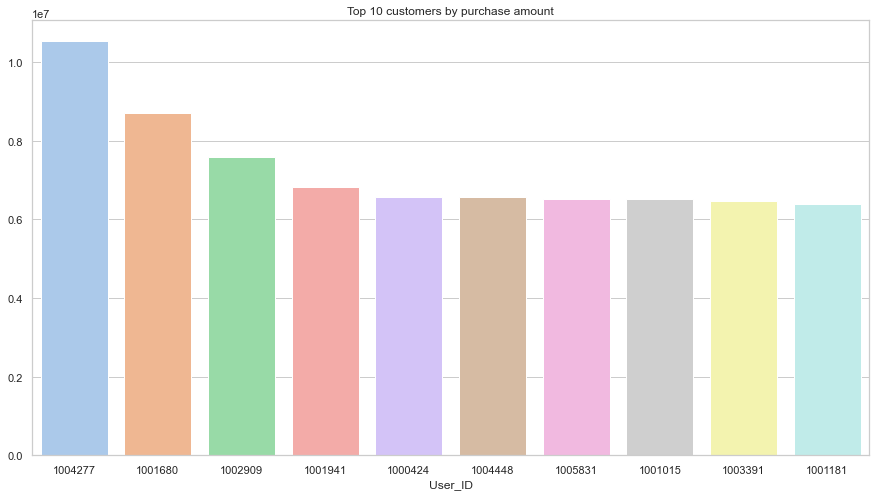

In [408]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
top_customers = df_train.groupby(by='User_ID').sum()['Purchase']
top_customers = top_customers.sort_values(ascending=False)
top_10 = top_customers.head(10)
sns.barplot(x=top_10.index,y=top_10.values, ax=ax, order=top_10.index)
ax.set_title("Top 10 customers by purchase amount")
plt.show()


Here we see the top 10 customers with the most transaction volume

### Feature Engineering
Since we are modeling a regression we need to convert our features into numerical values. We do this with one hot encoding. Ordinal values can be assigned to a certain range with a label encoder so that the ordinal order is maintained.

We also try to generate new features based on the data exploration.

Finally, we check the correlations between the features and then decide whether to use all features or whether, for example, multicollinearity exists between certain features so that we have to remove the feature.

In [ ]:
df_bin = None
df_city_bin = None
df_gender_bin = None
df_city_years_bin = None
df_age_bin = None
df_city_bin = pd.get_dummies(df_train['City_Category'])
df_gender_bin = pd.get_dummies(df_train['Gender'])
df_city_years_bin = pd.get_dummies(df_train['Stay_In_Current_City_Years'])
df_age_bin = pd.get_dummies(df_train['Age'])
df_bin = pd.concat([df_city_bin,df_gender_bin,df_city_years_bin,df_age_bin,], axis=1)

Now we have encoded the categorial values for age, city category, gender and how long the customer has lived in the city into a label of 0 or 1.

Also, instead of dropping the label cateogy due to missing values, we will use it as a binary feature: has category 3 or not.

In [403]:
df_cat3_bin= None
df_cat3_bin = df_train.Product_Category_3.apply(lambda x: 0 if pd.isnull(x) else 1)
df_cat3_bin.rename('cat_3_bin', inplace=True)
df_cat3_bin

23824     1
222561    1
119092    1
447536    1
152836    1
         ..
550063    0
550064    0
550065    0
550066    0
550067    0
Name: cat_3_bin, Length: 550068, dtype: int64

The same for category 2

In [404]:
df_cat2_bin = None
df_cat2_bin = df_train.Product_Category_2.apply(lambda x: 0 if pd.isnull(x) else 1)
df_cat2_bin.rename('cat_2_bin', inplace=True)
df_cat2_bin

23824     1
222561    1
119092    1
447536    1
152836    1
         ..
550063    0
550064    0
550065    0
550066    0
550067    0
Name: cat_2_bin, Length: 550068, dtype: int64

Now lets put everything together and plot the heatmap

In [405]:
df_all_feats = None
df_all_feats = pd.concat([df_train, df_bin,df_cat2_bin,df_cat3_bin], axis=1)

Drop the unecessary features 

In [416]:
df_final = None
df_final = df_all_feats.drop(['User_ID', 'Product_ID', 'Gender', 'Age', 'City_Category','Stay_In_Current_City_Years'], axis=1)
df_final.dtypes

Occupation              int64
Marital_Status          int64
Product_Category_1      int64
Product_Category_2    float64
Product_Category_3    float64
Purchase                int64
A                       uint8
B                       uint8
C                       uint8
F                       uint8
M                       uint8
0                       uint8
1                       uint8
2                       uint8
3                       uint8
4+                      uint8
0-17                    uint8
18-25                   uint8
26-35                   uint8
36-45                   uint8
46-50                   uint8
51-55                   uint8
55+                     uint8
cat_2_bin               int64
cat_3_bin               int64
dtype: object

We see that we only have numeric variables in our dataframe that we need for a regression. 

We can now generate the correlation matrix.

<AxesSubplot:>

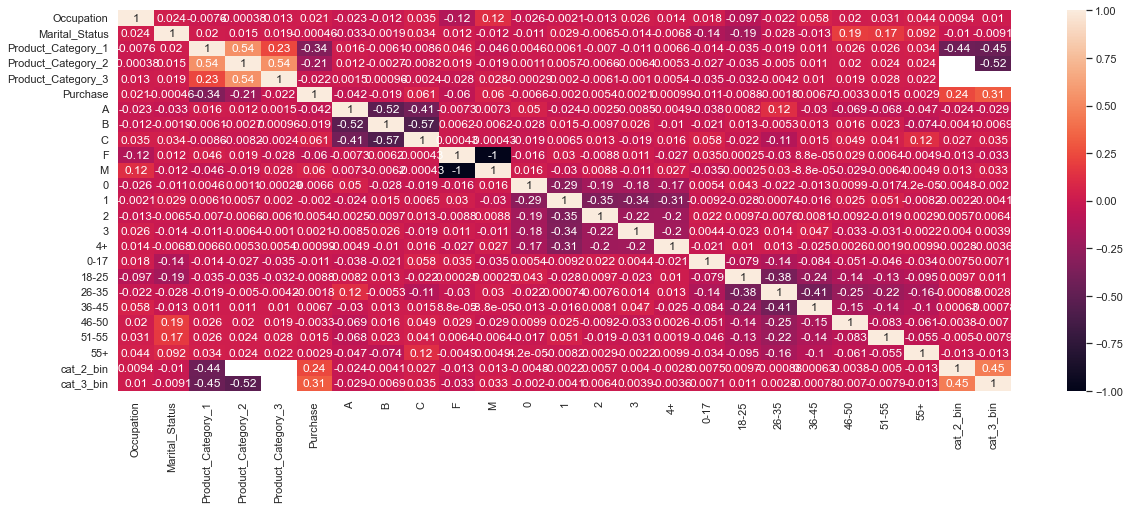

In [419]:
import seaborn as sns
corr = df_final.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)

We are interested in how the features correlate with our target variable purchase and how they correlate with themselves.

It is noticeable that the features we developed from category 2 and 3 instead of deleting them describe the target variable better than the original two features. 

Married status correlates slightly with age group 46-50, where most are married.

In addition, feature C, which represents a city type, correlates with age 55+. This could indicate that type C represents a rural area where retirees settle or an affluent area.

The city type A correlates with the age group 25-36, which indicates an urban area.

Woman and man also strongly correlate, here one could also make a binary variable gender instead of two (F and M).

The regions of the cities also correlate slightly with the number of years (1,2,3,4+) one has lived in the city. In addition, age groups have a slight to high correlation.

The city groups (A,B,C) have a high correlation.

Since the binary category features correlate with the normal category features, we remove the Product_Category_2 and Product_Category_3 features.

We also remove married status as it correlates with age and has almost no correlation with the target variable. 

The same could be done for the city types, but here the correlation between the features is very low, so we do not do this for now.


In [453]:
df_prime = df_final.drop(["Product_Category_2","Product_Category_3",'Marital_Status'], axis=1)

## Model

We create a model from the features obtained. We split our data and separate the target variable from the features.

In [454]:
y = df_prime['Purchase']
X = df_prime.drop('Purchase', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

We create a simple baseline model 

In [488]:
sc = StandardScaler()
lr = LinearRegression()
lr.fit(X_train, y_train)
coeff_df = pd.DataFrame(lr.coef_, X.columns, columns=['Coefficient'])
y_pred = lr.predict(X_test)

# mean squared error
mse = mean_squared_error(y_test, y_pred)
# mean absolute error
mae = mean_absolute_error(y_test, y_pred)

print("RMSE Error:", np.sqrt(mse))
print("MSE Error:", mse)
print("MAE Error:", mae)

# r2 score (variance)
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)



RMSE Error: 4612.705617047502
MSE Error: 21277053.109541573
MAE Error: 3514.187071550742
R2 Score: 0.15801319061902208


the r square value of only 15 percent is relatively poor.

The MAE is $3514, which is relatively good, our standard deviation of the target variable is sigma = 5023 and the median is 9263.

The error is somewhat more than half of the standard deviation, which is ok.

In [464]:
print(coeff_df)

                     Coefficient
Occupation          6.253068e+00
Product_Category_1 -3.065337e+02
A                  -2.806380e+13
B                  -2.806380e+13
C                  -2.806380e+13
F                   8.194582e+13
M                   8.194582e+13
0                   3.826531e+12
1                   3.826531e+12
2                   3.826531e+12
3                   3.826531e+12
4+                  3.826531e+12
0-17               -1.332602e+14
18-25              -1.332602e+14
26-35              -1.332602e+14
36-45              -1.332602e+14
46-50              -1.332602e+14
51-55              -1.332602e+14
55+                -1.332602e+14
cat_2_bin           5.076626e+02
cat_3_bin           2.008435e+03


We see the performance of our baseline model and the coefficients.

As already seen in the correlation matrix, the product categorie features have a high correlation and therefore a higher coefficient value.

The feature occupation has the highest coefficient.

Lets try to improve the performance of the simple linear regression model with a gradient boosted random regressor and hyperparameter tuning

In [489]:
model = GradientBoostingRegressor(n_estimators = 100, max_depth = 5, min_samples_split = 2, learning_rate = 0.1, )
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# mean squared error
mse = mean_squared_error(y_test, y_pred)
# mean absolute error
mae = mean_absolute_error(y_test, y_pred)

print("RMSE Error:", np.sqrt(mse))
print("MSE Error:", mse)
print("MAE Error:", mae)

# r2 score (variance)
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

RMSE Error: 2982.9079696415865
MSE Error: 8897739.955351293
MAE Error: 2246.7636365245617
R2 Score: 0.6478939241662074


The gradient boosted regressor has significantly improved performance.

The MAE is 2246 (baseline 3514) and the RMSE is 2982 (baseline 4612).

The R squared value is also significantly better and jumped from 15 % to 64 %.

We are now trying to improve the model even further with hyperparameter tuning. To do this, we make a custom scorer again and optimize the model for the mse in a randomized grid search.

*(Note: grid search took 192 minutes, the result can be retrieved in the file cv_results_regression.csv)*

In [444]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

def custom_scorer(y_true, y_pred, actual_scorer):
    score = np.nan
    try:
        score = actual_scorer(y_true, y_pred)
    except ValueError: 
        pass
    return score


param_grid = {
    'max_depth': [4,6,8,10],
    'n_estimators': [100, 500, 800, 1000]

    }


mse = make_scorer(custom_scorer, actual_scorer=mean_squared_error)
###
model = RandomizedSearchCV(GradientBoostingRegressor(), param_grid, verbose=3, scoring={"mse": mse}, return_train_score=False, refit=False)
model.fit(X_train,y_train)
print(model.cv_results_)
rs_result_df = pd.DataFrame(model.cv_results_) 
rs_result_df.to_csv('cv_results_regression.csv')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=8, n_estimators=500; mse: (test=8554553.765) total time= 3.9min
[CV 2/5] END max_depth=8, n_estimators=500; mse: (test=8493622.288) total time= 3.9min
[CV 3/5] END max_depth=8, n_estimators=500; mse: (test=8495018.882) total time= 4.0min
[CV 4/5] END max_depth=8, n_estimators=500; mse: (test=8650058.255) total time= 4.1min
[CV 5/5] END max_depth=8, n_estimators=500; mse: (test=8483837.191) total time= 4.2min
[CV 1/5] END max_depth=6, n_estimators=800; mse: (test=8540328.949) total time= 5.2min
[CV 2/5] END max_depth=6, n_estimators=800; mse: (test=8506362.494) total time= 5.2min
[CV 3/5] END max_depth=6, n_estimators=800; mse: (test=8471419.789) total time= 5.0min
[CV 4/5] END max_depth=6, n_estimators=800; mse: (test=8627432.826) total time= 4.8min
[CV 5/5] END max_depth=6, n_estimators=800; mse: (test=8477323.016) total time= 4.8min
[CV 1/5] END max_depth=6, n_estimators=500; mse: (test=8564870.634) t

In [ ]:
## optional: read grid search result df from csv ##
rs_result_df = pd.read_csv("cv_results_regression.csv")
##################################################


We implement a function to plot the grid search reesults

<function matplotlib.pyplot.show(close=None, block=None)>

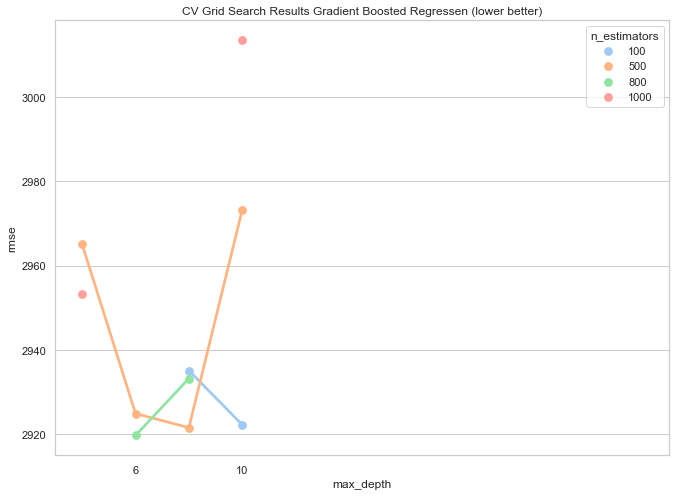

In [483]:
def plot_cv_results(cv_results, param_z, param_x, metric='mean_test_mse'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """

    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    #col_z = param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_z,data=cv_results,ci=99, n_boot=64, ax=ax)
    ax.set_title("CV Grid Search Results Gradient Boosted Regressen (lower better)")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    #ax.set(ylim=(1, 10000))
    #ax.set(xlim=(0, 11))
    ax.legend(title=param_z)
    locs, labels = plt.xticks()  # Get the current locations and labels.
    plt.xticks([1,3,5,7,9,11])  # Set label locations.
    return fig

rmse_rs_result_df = rs_result_df
rmse_rs_result_df['rmse'] = rmse_rs_result_df.mean_test_mse.apply(lambda x: np.sqrt(x))
plot_cv_results(rmse_rs_result_df, 'n_estimators', 'max_depth', metric='rmse')
plt.show

We see the results of the grid search where low values are better.

As parameters we have set the depth of the tree and the number of trees.

With 800 trees and a depth of 6, the model achieved the best MSE. We now create the model with these hyperparameters

In [490]:
optimized_model = GradientBoostingRegressor(n_estimators = 800, max_depth = 6, min_samples_split = 2, learning_rate = 0.1)
optimized_model.fit(X_train, y_train)

y_pred = optimized_model.predict(X_test)

# mean squared error
mse = mean_squared_error(y_test, y_pred)
# mean absolute error
mae = mean_absolute_error(y_test, y_pred)

print("RMSE Error:", np.sqrt(mse))
print("MSE Error:", mse)
print("MAE Error:", mae)

# r2 score (variance)
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

RMSE Error: 2930.6155396159547
MSE Error: 8588507.441038514
MAE Error: 2187.2104630584276
R2 Score: 0.6601310369253193


We were able to lower the MAE from 2246 to 2187 and the RMSE from 2982 to 2930.

The R squared has worsened a bit but this is not a bad thing since RMSE and MAE have improved and in this case are more indicative of the performance of our model.

We can now predict our customers' expected transaction volumes with an accuracy of almost $2,000. The model is ready for deployment.